In [20]:
import pandas as pd
import numpy as np
from numpy import newaxis

import random
import itertools

import os
from os import listdir
from os.path import isfile
import math

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.collections
from matplotlib import gridspec

import datetime
from tqdm import *

import keras
from keras.applications import *
import lightgbm as lgbm

from scipy import ndimage
from scipy import misc
from scipy import signal
import cv2
plt.ion()
plt.show()

import keras

from keras.layers import Input, Dense, Lambda, Layer, Conv2D, MaxPooling2D,UpSampling2D, concatenate, Dropout,Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint


import collections
from collections import *

import tensorflow as tf
from IPython.display import clear_output
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


![title](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [2]:
# !dir data/stage1_test

In [3]:
trainDir = 'data/stage1_train/'
testDir = 'data/stage1_test/'
unetSize = 256

In [4]:
fileIDs = listdir(trainDir)
testIDs = listdir(testDir)

In [5]:
def getFileImage(fileID, dd=trainDir):
    if not os.path.isfile(dd + fileID + '/images/'+ fileID + '.png'):
        print('Missing image file with ID %s' % fileID)
        return None
    else:
        return misc.imread(dd + fileID + '/images/'+fileID + '.png')

In [6]:
def drawContour(x):
    res = signal.convolve2d(x, [[1,1,1],[1,1,1],[1,1,1]], 'same')
    indices = np.where((res/255 < 9) & (x == 255)==True)
    x[indices[0],indices[1]] = 128
    return x

def getFileMasks(fileID):
    if not os.path.isdir(trainDir + fileID + '/masks/'):
        print('Missing image file with ID %s' % fileID)
        return None
    else:
        theMask = None
        for mask in listdir(trainDir + fileID + '/masks/'):
            m = misc.imread(trainDir + fileID + '/masks/' + mask)
            m = drawContour(m)
            if theMask is None:
                theMask = m
            else:
                theMask = theMask + m
        return theMask
        


In [7]:
def getMaskPixels(i,j, mask):
    result = np.zeros(mask.shape)
    WHITE_PIXEL = 255
    if np.max(mask) <= 1:
        WHITE_PIXEL = 1
    result[i,j] = WHITE_PIXEL
    neighbors = [] + []

    toiterate = []

    toiterate.append((i,j))
    idx = 0
    while (idx < len(toiterate)):
#         print(toiterate)
        idxx = toiterate[idx][0]
        idxy = toiterate[idx][1]

        for newelem in [ (idxx+x,idxy+y) 
                    for x,y in itertools.product(range(-1,2), range(-1,2)) 
                    if  idxx+x < mask.shape[0] and idxx+x >= 0 and
                        idxy+y < mask.shape[1] and idxy+y >= 0 and
                        mask[idxx+x,idxy+y]==WHITE_PIXEL and not((idxx+x,idxy+y) in toiterate)]:
            toiterate.append(newelem)

        idx = idx+1
#         print(idx, len(toiterate))

    return toiterate
    
# getMaskPixels(1, 14, mask)

def splitMask(mask):
    allMasks = []
    whitePixels = list(zip(*np.where(mask == 255)))
    while len(whitePixels) > 0 :
        pixels = getMaskPixels(whitePixels[0][0],whitePixels[0][1], mask)

        whitePixels = [p for p in whitePixels if p not in pixels]
        
        pixels = list(zip(*pixels))
        mask[pixels[0],pixels[1]] = 0
        
        m = np.zeros(mask.shape)
        m[pixels[0],pixels[1]] = 255
        allMasks.append(m)       
    return allMasks

# mask = getFileMasks(fileIDs[5])
# plt.imshow(mask, cmap = 'gray')
# for i in splitMask(mask.copy())[:3]:
#     plt.imshow(i, cmap = 'gray')
#     plt.figure(figsize=(18,18));



In [8]:
def getSubmissionForFile(fileID, masks):
    print('Found %s' % len(masks))
    results = []
    for mask in masks:
        whitePixels = np.where(np.reshape(mask,-1, order='F')==255)[0]+1
#         print(len(whitePixels))
        result = []
        last = whitePixels[0]
        lastlen = 0

        for i in whitePixels:
            if i != last+1:
                result.append(lastlen+1)
                result.append(i)
                lastlen=0
            else:
                lastlen = lastlen+1
            last = i
        result.append(lastlen+1)
        results.append(result[1:])
    return results

In [9]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def imgResizeNormalizeAndGrayscale(img, newDimension, normalize = True, grayscale = True):

        
    # todo: check both dimensions, or either
    if img.shape[0] > newDimension[0]: 
        img = cv2.resize(img,newDimension, cv2.INTER_AREA)
    else:
        img = cv2.resize(img,newDimension, cv2.INTER_CUBIC)
        
    if normalize :
        img = cv2.normalize(img, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F, dst=None)
    # convert image to grayscale only if it has 3 dimensions - it is not already grayscale
    if grayscale and len(img.shape) > 2 and img.shape[2] >= 3:
        img = rgb2gray(img)
    return img
    
# evaluateImage(40)

(256, 320, 4)


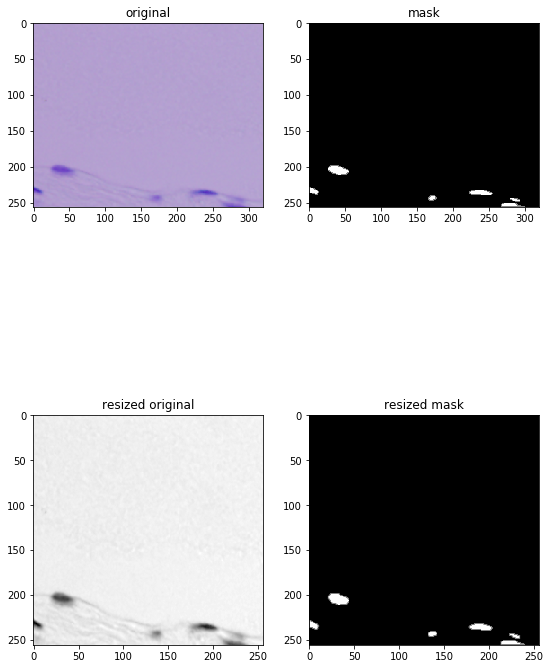

In [10]:

def evaluateImage(imageID, model=None):
    plt.figure(figsize=(14,14))

    img = getFileImage(fileIDs[imageID])

    print(img.shape)
    plt.subplot(231)
    plt.grid(False)
    plt.title('original')
    plt.imshow(img, cmap='gray')
    plt.subplot(234)
    plt.grid(False)
    plt.title('resized original')
    plt.imshow(imgResizeNormalizeAndGrayscale(img, (unetSize,unetSize)), cmap='gray')

    if model is not None:
        pred = model.predict(np.stack([imgResizeNormalizeAndGrayscale(img,(unetSize,unetSize))])[:,:,:, newaxis])[0,:,:,0]
        print(pred.shape)
        plt.subplot(233)
        plt.grid(False)
        plt.title('prediction')
        plt.imshow(pred, cmap='gray')
        plt.subplot(236)
        plt.grid(False)
        plt.title('resized prediction')
        plt.imshow(imgResizeNormalizeAndGrayscale(pred, (unetSize,unetSize)), cmap='gray')
    
    img = getFileMasks(fileIDs[imageID])
    plt.subplot(232)
    plt.grid(False)
    plt.title('mask')
    plt.imshow(img, cmap='gray')
    plt.subplot(235)
    plt.grid(False)
    plt.title('resized mask')
    plt.imshow(imgResizeNormalizeAndGrayscale(img,(unetSize,unetSize)), cmap='gray')
    


evaluateImage(40)
# evaluateImage(650, unetAE)

In [11]:
if os.path.isfile('data/inputImgGrayscaleNormalized.npy'):
    inputImg = np.load('data/inputImgGrayscaleNormalized.npy')
    masks = np.load('data/masksGrayscaleNormalized.npy')
else:
    inputImg = []
    masks = []
    for fileId in fileIDs:
        print('.', end ='')
        inputImg.append(imgResizeNormalizeAndGrayscale(getFileImage(fileId), (unetSize, unetSize)))
        masks.append(imgResizeNormalizeAndGrayscale(getFileMasks(fileId), (unetSize, unetSize)))
    inputImg = np.stack(inputImg)
    inputImg = inputImg[:,:,:, newaxis]
    masks = np.stack(masks)
    masks = masks[:,:,:, newaxis]
    np.save('data/masksGrayscaleNormalized.npy', masks)
    np.save('data/inputImgGrayscaleNormalized.npy', inputImg)
    
    
    
masks.shape
inputImg.shape

(670, 256, 256, 1)

(670, 256, 256, 1)

In [12]:
# !rm data/*.npy

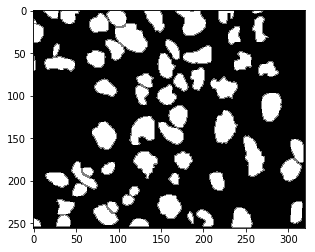

In [13]:
fileID = fileIDs[0]
plt.grid(False)
mask = getFileMasks(fileID)
plt.imshow(mask, cmap = 'gray')

In [14]:
# i = 5

# for x in range(5):
#     i = random.randint(0,len(fileIDs)-1)
#     evaluateImage(i)

## U net

In [15]:
# inputImg = []
# masks = []

![title](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [16]:
# model PC1

In [17]:
# imgsize = unetSize
# inp = Input(shape=(imgsize,imgsize,1), name='input')

# channels = 64
# x = Conv2D(channels, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(inp)
# x_512 = Conv2D(channels, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(x)

# x = MaxPooling2D(pool_size=(2, 2), padding='same')(x_512)

# channels = 128
# x = Conv2D(channels, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(x)
# x_256 = Conv2D(channels, (3,3), activation='relu', padding='same')(x)



# channels = channels * 2
# x = Conv2D(channels, (3,3),activation='elu', kernel_initializer='he_normal', padding='same')(x)
# x_128 = Conv2D(channels, (3,3), activation='elu', kernel_initializer='he_normal',padding='same')(x)


# x = UpSampling2D((2, 2))(x_256)

# c = concatenate([x_512,x])

# x = Conv2D(channels, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(c)
# channels =64
# x = Conv2D(channels, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(x)
# x = Conv2D(channels, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(x)

# out = Conv2D(1, (1,1), activation='sigmoid', padding='same')(x)


# unetAE = Model(inp,out)
# unetAE.compile(optimizer='adadelta', loss='binary_crossentropy')

# unetAE.summary()


# x = MaxPooling2D(pool_size=(2, 2), padding='same')(x_128)


In [21]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

In [22]:
imgsize = unetSize

def uconvx2(x, channels):
#     x = Conv2D(channels, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(x)
#     x = Dropout(0.1) (x)
#     x = Conv2D(channels, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(x)
    x = Conv2D(channels, (3,3), activation='relu', padding='same')(x)
#     x = Dropout(0.1) (x)
    x = Conv2D(channels, (3,3), activation='relu', padding='same')(x)
    return x

def uConvDown(x, channels):
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = uconvx2(x, channels)
    return x

def uConvUp(x, grey, channels):
    x = UpSampling2D((2, 2))(x)
    x = uconvx2(concatenate([x,grey]), channels)
    return x

inp = Input(shape=(imgsize,imgsize,1), name='input')

startChannel = 64
numChannels = 4
layer = []

layer.append(uconvx2(inp, startChannel))
for i in range(1, numChannels+1):
    layer.append(uConvDown(layer[-1],startChannel*(2**i)))

middle = layer[-1]

for i in range(numChannels+1,1,-1):
    layer.append(uConvUp(layer[-1], layer[i-2], startChannel*(2**i)))

out = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(layer[-1])


mid = Model(inp, middle)
unetAE = Model(inp,out)
unetAE.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])
# unetAE.compile(optimizer='adam', loss='binary_crossentropy')

unetAE.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input (InputLayer)               (None, 256, 256, 1)   0                                            
____________________________________________________________________________________________________
conv2d_20 (Conv2D)               (None, 256, 256, 64)  640         input[0][0]                      
____________________________________________________________________________________________________
conv2d_21 (Conv2D)               (None, 256, 256, 64)  36928       conv2d_20[0][0]                  
____________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)   (None, 128, 128, 64)  0           conv2d_21[0][0]                  
___________________________________________________________________________________________

In [23]:
# testIdx = random.randint(0, len(testIDs))

# img = getFileImage(testIDs[testIdx], testDir)
# unetAE.predict(np.stack([imgResizeNormalizeAndGrayscale(img,(unetSize,unetSize))])[:,:,:, newaxis])[0,:,:,0]

In [31]:

class PlotLosses(keras.callbacks.Callback):
    def __init__(self):
        self.initVars()
    
    def initVars(self):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = [] # self validation
        self.fig = plt.figure()
        self.logs = []
        self.lr = []
        
    def on_train_begin(self, logs={}):
        self.initVars()

    def on_epoch_end(self, epoch, logs={}):
        self.i += 1
        
        print('bi = ', i)
        clear_output(wait=True)
        print('i = ', i)
#         if self.i% 5 != 0:
#             return
        
        # make a prediction
        testIdx = random.randint(0, len(testIDs)-1)
        img = getFileImage(testIDs[testIdx], testDir)
        plt.figure(figsize=(16,15))
        plt.subplot(221)
        plt.grid(False)
        plt.title('original')
        plt.imshow(img, cmap='gray')
        
        pred = unetAE.predict(np.stack([imgResizeNormalizeAndGrayscale(img,(unetSize,unetSize))])[:,:,:, newaxis])[0,:,:,0]
        plt.subplot(222)
        plt.grid(False)
        plt.title('prediction')
        plt.imshow(pred, cmap='gray')
        
        
        curloss = logs.get('loss')
        self.losses.append(curloss)
        self.val_losses.append(logs.get('val_loss'))
        self.logs.append(logs)
        self.x.append(self.i)
        
        plt.subplot(223)
        plt.plot(np.arange(len(self.losses)), self.losses, label="train loss")
        plt.plot(np.arange(len(self.losses)), self.val_losses, label="val loss")

        plt.legend()
        plt.show();

        
myPlotLosses = PlotLosses()
myPlotLosses.initVars();

In [ ]:
batchSize = 4
# for i in range(0, len(inputImg), 20) :
#     x_train = inputImg[i: (i + 20)][:,:,:,:3]/255.0
#     y_train = masks[i: (i + 20)]/255.0
#     unetAE.fit(x_train, y_train,

earlystopper = EarlyStopping(patience=3, verbose=1)
checkpointer = ModelCheckpoint('data/model1.h5', verbose=1, save_best_only=True)
unetAE.fit(inputImg, masks, epochs=30, batch_size=batchSize, shuffle=True, verbose=1 
           ,callbacks=[myPlotLosses, checkpointer]
#                 validation_data=(x_test, x_test),
              )

In [42]:
unetAE.save('data/pc_model.h5')  # creates a HDF5 file 'my_model.h5'
# del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
# model = load_model('data/pc_model.h5')

In [ ]:
# checkpointer = ModelCheckpoint('data/model1.h5', verbose=1, save_best_only=True)
# results = unetAE.fit(inputImg, masks, epochs=30, batch_size=batchSize, shuffle=True, verbose=1,
#                     callbacks=[myPlotLosses, checkpointer])
# unetAE = load_model('data/model1.h5', custom_objects={'mean_iou': mean_iou})

In [57]:
pred = unetAE.predict(inputImg[570:575])

(520, 696, 4)
(256, 256)


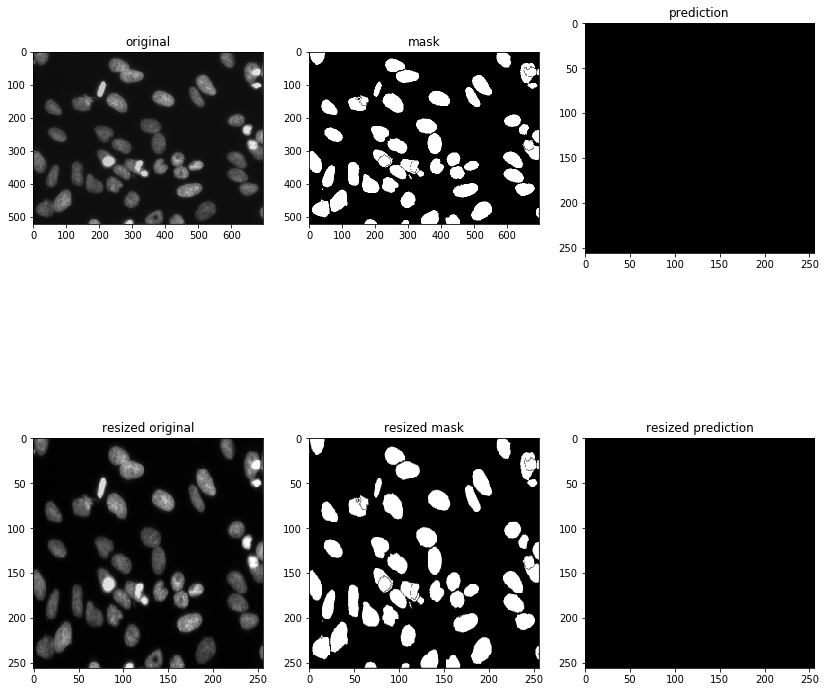

In [58]:
evaluateImage(650, unetAE)

In [ ]:
testIDs

In [29]:
# testIDs = fileIDs[0:3]
model = unetAE

(512, 680, 3) (512, 680)


Found 15
(520, 696, 4) (520, 696)


Found 21
(256, 256, 4) (256, 256)


Found 33
(256, 256, 4) (256, 256)


Found 7
(512, 640, 4) (512, 640)


Found 14
(512, 680, 3) (512, 680)


Found 64
(256, 256, 4) (256, 256)


Found 12
(519, 161, 3) (519, 161)


Found 50
(256, 256, 4) (256, 256)


Found 8
(256, 256, 4) (256, 256)


Found 85
(256, 256, 4) (256, 256)


Found 12
(512, 640, 4) (512, 640)


Found 26
(256, 256, 4) (256, 256)


Found 10
(256, 256, 4) (256, 256)


Found 7
(519, 253, 3) (519, 253)


Found 39
(524, 348, 3) (524, 348)


Found 97
(519, 253, 3) (519, 253)


Found 48
(512, 680, 3) (512, 680)


Found 37
(519, 162, 3) (519, 162)


Found 37
(512, 640, 4) (512, 640)


Found 8
(520, 348, 3) (520, 348)


Found 160
(256, 256, 4) (256, 256)


Found 18
(260, 347, 4) (260, 347)


Found 105
(260, 347, 4) (260, 347)


Found 26
(256, 256, 4) (256, 256)


Found 11
(519, 253, 3) (519, 253)


Found 61
(390, 239, 4) (390, 239)


Found 2
(256, 256, 3) (256, 256)


Found 44
(520, 696, 4) (520, 696)


Found 22
(512, 640, 4) (512, 640)


Found 5
(256, 256, 3) (256, 256)


Found 38
(520, 348, 3) (520, 348)


Found 192
(512, 640, 4) (512, 640)


Found 80
(256, 256, 4) (256, 256)


Found 12
(512, 680, 3) (512, 680)


Found 51
(524, 348, 3) (524, 348)


Found 50
(520, 696, 4) (520, 696)


Found 23
(256, 256, 4) (256, 256)


Found 14
(524, 348, 3) (524, 348)


Found 47
(512, 680, 3) (512, 680)


Found 75
(256, 256, 3) (256, 256)


Found 31
(519, 161, 3) (519, 161)


Found 34
(520, 348, 3) (520, 348)


Found 162
(520, 348, 3) (520, 348)


Found 142
(512, 680, 3) (512, 680)


Found 20
(512, 680, 3) (512, 680)


Found 91
(519, 162, 3) (519, 162)


Found 40
(256, 256, 4) (256, 256)


Found 83
(256, 256, 4) (256, 256)


Found 31
(512, 680, 3) (512, 680)


Found 42
(256, 256, 4) (256, 256)


Found 10
(524, 348, 3) (524, 348)


Found 114
(512, 640, 4) (512, 640)


Found 15
(256, 256, 4) (256, 256)


Found 11
(256, 256, 4) (256, 256)


Found 7
(256, 256, 4) (256, 256)


Found 13
(512, 640, 4) (512, 640)


Found 4
(256, 256, 3) (256, 256)


Found 41
(260, 347, 4) (260, 347)


Found 34
(519, 253, 3) (519, 253)


Found 59
(256, 256, 4) (256, 256)


Found 16
(520, 696, 4) (520, 696)


Found 31
(256, 256, 4) (256, 256)


Found 6
(260, 347, 4) (260, 347)


Found 138
(512, 640, 4) (512, 640)


Found 19


{'0114f484a16c152baa2d82fdd43740880a762c93f436c8988ac461c5c9dbe7d5': [[45105,
   5,
   45360,
   9,
   45615,
   11,
   45869,
   13,
   46125,
   14,
   46381,
   13,
   46637,
   13,
   46894,
   11,
   47151,
   8,
   47409,
   4],
  [28248, 2],
  [50280,
   6,
   50534,
   10,
   50789,
   12,
   51044,
   14,
   51299,
   15,
   51554,
   16,
   51809,
   17,
   52065,
   17,
   52321,
   17,
   52577,
   16,
   52833,
   16,
   53089,
   15,
   53345,
   15,
   53602,
   12,
   53860,
   9],
  [11148,
   6,
   11402,
   9,
   11657,
   11,
   11912,
   12,
   12167,
   13,
   12422,
   14,
   12678,
   13,
   12933,
   14,
   13189,
   13,
   13445,
   13,
   13701,
   12,
   13957,
   11,
   14214,
   9,
   14472,
   5],
  [31633,
   5,
   31885,
   11,
   32139,
   14,
   32394,
   15,
   32649,
   17,
   32905,
   17,
   33160,
   18,
   33415,
   19,
   33671,
   19,
   33927,
   19,
   34183,
   18,
   34439,
   17,
   34696,
   14,
   34952,
   13,
   35209,
   11,
   35467

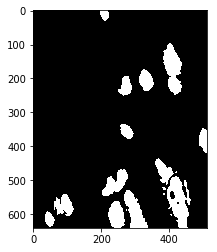

In [32]:
encodedPredictions = {}
for fileID in testIDs:
    img = getFileImage(fileID, testDir)
#     pred = model.predict(imgResizeNormalizeAndGrayscale(img,(512,512))[newaxis,:,:,:3])[0,:,:,0]
    pred = unetAE.predict(np.stack([imgResizeNormalizeAndGrayscale(img,(unetSize,unetSize))])[:,:,:, newaxis])[0,:,:,0]
    print(img.shape, img.shape[:2])
#     pred = np.round(imgResizeNormalizeAndGrayscale(pred, img.shape[:2]) ) * 255
    pred = np.round(imgResizeNormalizeAndGrayscale(pred, img.shape[:2]) )
    plt.figure()
    plt.imshow(pred, cmap = 'gray')
    encodedPredictions[fileID] = getSubmissionForFile(fileID,splitMask(pred))
#     break
    
encodedPredictions    

In [ ]:
plt.imshow(img)

In [ ]:
encodedPredictions.keys()

In [35]:
from datetime import *
datetime.now()

datetime.datetime(2018, 2, 6, 0, 23, 25, 24669)

In [37]:
sub = pd.DataFrame(columns=['ImageId','EncodedPixels'])
print(len(sub))

for key,value in encodedPredictions.items():
    for nuclei in value:
        sub.loc[len(sub),:] = [key, ' '.join(map(str, nuclei))]

0


In [38]:
filename = 'data/submission' + datetime.now().strftime('%Y-%m-%d_%H-%M')+ '.csv.gzip'

sub.to_csv(filename, compression='gzip', index=False)

In [36]:
filename = 'data/submission' + datetime.now().strftime('%Y-%m-%d_%H-%M')+ '.csv'
file = open(filename,'w') 

file.write('ImageId\tEncodedPixels\n')
for key,value in encodedPredictions.items():
    for nuclei in value:
        file.write(key + '\t' + ' '.join(map(str, nuclei)) + '\n')
file.close() 



22

5597

74

81

255

110

137

81

132

126

129

121

126

152

4697

115

101

575

494

500

290

437

503

174

474

362

545

603

461

141

209

395

869

206

164

312

341

100

137

73

121

194

129

241

129

129

73

153

176

157

89

137

129

125

194

188

168

137

197

204

153

259

81

139

169

139

113

164

97

73

141

89

113

151

137

105

97

357

426

352

589

325

458

773

503

632

198

294

513

502

297

465

92

711

79

489

330

408

202

405

170

137

83

395

339

93

119

74

159

472

119

92

295

122

152

197

1271

254

1022

174

190

92

139

380

111

334

92

193

222

119

122

756

168

101

183

313

92

83

188

587

627

137

101

183

128

392

280

274

264

270

119

119

101

187

110

196

129

159

81

180

154

172

171

190

223

142

109

9105

97

1689

225

393

7020

105

1809

153

113

1105

81

161

1427

113

326

225

145

121

113

241

289

1273

225

1037

201

456

2083

1409

369

2131

209

3179

233

7688

6036

121

89

4438

86

143

177

523

96

1737

133

1124

233

153

281

151

73

198

187

207

195

129

193

75

163

177

268

197

133

145

150

166

153

211

220

240

73

110

164

86

169

286

163

107

179

205

142

135

214

141

151

179

209

233

187

202

105

155

213

185

273

70

113

215

175

207

204

137

82

188

200

195

131

89

193

363

268

313

269

136

120

154

130

259

113

140

146

131

129

146

141

121

121

179

158

184

213

208

93

159

133

129

153

113

121

81

97

89

201

73

137

131

141

169

121

121

219

121

129

129

236

623

306

484

83

2782

218

418

74

1691

423

92

92

700

83

128

101

460

2332

83

83

92

101

83

119

413

168

197

195

175

206

171

81

141

159

204

234

233

73

121

164

141

105

673

1633

1836

25489

104

167

92

100

79

1915

85

97

121

217

2092

768

110

214

129

634

3324

73

94

878

128

289

89

81

89

1579

121

412

1179

74

639

215

101

155

153

128

218

371

378

105

254

281

161

89

281

233

217

100

155

129

97

173

191

153

145

105

371

101

174

137

361

119

384

388

218

81

114

73

73

254

161

265

308

169

93

128

137

99

110

284

217

225

142

225

257

128

215

254

137

137

128

110

107

385

209

121

541

218

83

110

96

441

128

389

153

89

341

73

92

209

272

222

145

182

92

92

263

254

345

128

137

217

225

128

308

145

161

184

185

322

272

164

87

1078

661

689

3533

130

323

543

631

447

85

81

1137

741

5447

128

387

101

401

137

105

97

586

487

4577

828

129

89

541

470

1942

290

135

119

743

563

2278

597

333

724

672

1235

131

711

1384

1046

1549

1433

120

280

119

389

188

272

218

112

198

206

74

189

130

391

511

243

221

233

147

362

133

74

351

905

155

318

101

83

83

123

74

74

122

307

311

284

153

3824

10931

845

562

963

121

369

121

705

265

6007

89

8348

2784

73

1961

121

281

97

1137

265

401

599

2345

833

958

5755

89

550

129

97

561

3274

177

333

489

378

684

378

92

110

1272

163

92

953

105

361

289

193

254

182

339

337

433

105

4726

121

259

277

294

305

89

479

1485

325

322

523

81

406

1067

308

549

193

365

289

110

264

369

146

110

288

1057

137

574

757

201

137

267

459

164

541

234

419

101

420

145

277

196

400

218

307

1333

111

137

153

233

408

2379

73

287

225

706

337

1127

932

211

461

359

575

645

145

289

113

333

129

397

806

281

173

101

463

304

236

290

161

218

157

259

385

126

621

851

1720

128

97

816

1288

129

155

97

121

209

83

1161

534

487

164

201

125

409

632

105

166

327

280

209

509

626

146

2584

1266

92

553

305

243

645

272

680

543

128

201

101

399

214

145

2392

119

74

1006

345

310

350

177

337

825

296

740

97

452

265

265

353

338

105

339

137

158

121

121

178

163

209

169

215

129

81

121

105

209

89

89

97

81

11857

124

193

97

177

97

109

107

197

319

345

173

81

118

93

113

105

110

113

137

115

121

73

146

191

105

121

134

108

105

73

97

73

126

113

89

116

73

81

188

145

113

97

205

73

105

133

204

122

189

132

118

81

73

296

105

73

140

97

89

89

97

81

73

81

164

157

97

193

81

122

175

118

116

97

89

121

73

113

81

109

73

97

105

165

89

107

106

121

73

79

86

97

97

89

147

81

81

81

131

131

81

89

140

81

10190

97

147

156

182

116

166

81

89

98

81

93

81

97

72

97

113

73

73

89

81

122

73

157

89

89

248

81

242

222

213

222

214

89

232

230

81

172

1180

681

1167

652

753

560

549

689

766

727

1034

335

647

281

731

891

582

789

1039

614

569

668

124

155

652

641

1156

1046

774

998

697

113

673

103

633

425

329

671

519

618

699

610

105

673

105

169

89

644

97

1601

113

1656

449

795

73

81

145

489

669

633

7284

97

1220

331

105

799

89

306

89

334

292

731

953

97

89

89

326

220

73

72

107

129

89

89

365

113

183

121

303

463

113

165

421

81

267

89

258

215

268

233

332

375

320

234

81

163

695

293

493

724

334

604

474

404

594

505

315

593

403

469

545

691

524

601

545

425

575

110

1080

608

441

101

1552

1366

404

273

89

1043

139

140

204

766

734

244

97

73

89

407

158

417

286

242

311

251

700

143

79

284

296

239

1342

72

161

258

958

271

97

81

325

105

193

593

105

647

434

200

544

113

113

73

922

301

873

137

263

347

81

345

182

119

89

89

498

504

153

200

185

207

256

73

296

129

299

247

89

213

1643

277

296

161

1144

362

217

323

207

607

241

129

3164

209

83

89

101

290

266

335

92

242

155

177

398

243

79

323

264

191

98

73

496

201

73

317

1628

984

245

73

640

97

164

81

603

169

92

177

191

289

110

111

128

356

419

353

900

366

232

498

268

101

119

92

240

364

471

129

145

137

326

984

119

309

523

167

293

348

161

554

272

258

281

2026

295

137

128

137

555

212

167

152

281

239

979

537

74

358

270

240

162

296

366

262

284

125

331

92

558

266

81

92

339

2678

542

841

241

759

341

222

254

811

128

119

293

861

247

428

404

406

161

130

439

291

338

607

97

3986

206

354

444

603

281

597

227

746

97

597

231

396

242

173

698

164

190

249

193

622

562

2177

146

491

83

881

105

461

378

73

151

92

81

83

445

105

152

369

73

128

97

121

97

145

959

83

92

101

83

92

146

128

110

101

589

101

405

217

157

110

83

112

110

110

119

103

101

74

734

761

1716

92

110

121

140

110

101

193

173

101

101

130

132

80

473

115

119

129

83

213

92

157

242

92

89

133

137

157

101

112

178

193

200

172

158

82

212

178

149

192

129

323

205

505

83

243

101

74

386

620

92

139

206

258

910

222

658

169

1377

101

644

92

173

11357

93

630

543

387

409

290

86

790

466

549

513

110

155

110

101

303

260

200

350

105

191

119

153

227

101

92

323

122

177

129

74

236

191

121

137

74

81

113

182

146

169

155

129

113

212

218

113

119

153

200

101

83

113

92

137

73

113

416

89

121

169

92

272

92

145

74

74

177

74

193

105

209

101

177

146

86

182

155

515

424

535

588

1230

501

591

351

554

474

344

74

170

343

274

355

363

150

131

161

101

209

218

150

105

121

199

89

105

227

121

254

201

156

253

162

81

97

89

119

137

137

182

153

105

177

93

249

74

137

137

105

371

121

86

74

110

274

129

155

110

92

129

177

255

101

119

101

142

227

216

113

191

119

173

101

74

74

81

263

381

201

128

129

2367

1154

170

73

228

82

246

152

223

151

83

167

110

224

162

73

206

874

469

289

83

367

2448

3433

108

89

93

259

374

240

83

89

991

116

130

119

634

137

74

101

128

2565

195

144

85

121

274

142

150

261

1019

147

320

272

254

676

523

886

213

173

899

211

92

242

990

161

581

161

673

522

171

506

254

83

92

3051

89

81

631

214

81

89

97

137

90

97

129

417

97

278

97

448

5801

145

293

89

113

130

93

415

631

194

506

300

153

89

283

1081

21217

305

1278

561

625

1657

97

761

121

177

1045

89

97

841

2281

281

705

1451

1553

2682

2948

241

1089

1825

801

241

463

1086

1704

171

793

633

359

329

209

690

198

191

110

658

121

629

227

228

262

299

344

400

174

166

267

217

431

520

509

119

81

625

1997

262

155

119

253

104

651

101

1245

190

1248

410

217

225

1208

96

105

485

121

320

161

589

662

113

335

423

648

369

185

544

338

173

185

495

1155

132

1988

164

258

164

850

302

169

439

322

317

275

137

625

561

478

272

447

137

276

144

137

560

90

318

318

219

801

655

89

169

234

385

169

245

2312

137

101

791

89

201

234

487

633

145

738

94

437

933

330

210

298

177

173

304

1036

1910

73

1880

272

155

394

287

161

270

327

221

291

998

326

193

239

290

227

426

590

5104

241

901

257

642

348

544

146

579

350

1213

471

86

851

712

128

984

193

859

527

362

411

128

129

168

794

270

161

129

289

400

330

200

386

515

299

207

257

250

1975

280

236

185

970

1144

105

247

936

641

97

227

218

217

177

155

101

89

657

209

199

361

128

5380

364

105

593

119

1241

1133

330

232

393

296

356

148

257

258

113

608

146

355

290

373

97

110

1107

113

473

7819

209

218

218

778

435

192

344

335

105

1319

1631

101

184

84

110

527

677

275

544

1776

380

92

526

193

305

6319

254

231

667

89

254

954

860

373

332

146

1527

744

110

402

268

459

261

424

97

1904

110

591

137

439

563

193

261

92

254

361

520

437

92

322

445

137

378

423

381

795

110

316

266

272

291

283

335

533

265

297

200

81

455

10057

155

92

113

163

206

245

201

503

221

187

110

113

92

74

1248

178

622

384

283

226

392

217

128

74

155

259

141

94

222

124

318

310

456

145

176

214

579

204

153

1334

147

89

306

190

270

337

89

160

81

83

131

253

81

74

89

421

81

164

73

137

129

90

158

319

171

256

150

212

290

162

122

287

193

315

219

92

166

97

272

193

686

409

158

775

108

146

242

105

161

113

101

123

83

74

234

83

537

153

167

613

133

434

72

74

378

72

258

171

191

301

32891

113

113

139

149

515

128

293

73

209

161

345

97

185

81

137

105

105

241

145

113

129

81

497

121

81

97

241

423

14903

161

89

201

481

97

3750

97

121

97

206

209

177

186

298

213

180

81

178

194

188

187

82

137

73

105

113

107

97

141

221

141

89

129

169

255

124

121

183

166

160

170

97

230

121

183

123

129

129

89

354

203

82

129

113

186

93

79

204

86

94

79

161

73

116

304

150

262

122

180

222

186

212

148

195

156

152

194

213

73

121

188

145

145

226

121

192

130

114

338

81

283

121

137

177

166

73

195

81

177

308

89

186

142

285

242

138

157

90

113

126

105

156

268

113

129

146

137

232

83

245

185

135

89

119

414

313

74

97

83

342

128

155

249

99

148

497

382

92

123

380

101

164

83

83

248

247

200

261

202

112

101

431

74

83

83

269

84

141

84

137

159

164

110

128

137

174

172

223

225

97

153

89

230

129

81

91

137

146

297

110

119

290

121

97

153

137

137

97

369

110

217

209

304

529

191

232

161

121

227

185

93

120

97

105

362

761

81

119

145

263

92

377

285

839

308

92

371

146

155

105

500

281

73

563

110

121

317

137

83

96

74

407

145

371

193

79

74

121

182

317

538

73

308

313

654

200

113

137

201

411

317

337

201

257

313

105

85

97

249

113

185

161

128

305

165

81

105

273

105

137

201

89

201

398

233

161

92

249

173

110

396

79

113

201

423

97

257

155

129

652

141

543

501

403

215

584

333

442

321

1027

155

388

110

275

229

146

238

81

73

170

134

140

213

252

112

129

181

120

129

131

81

105

224

153

182

154

185

155

256

153

174

201

211

187

257

1460

1135

789

393

75

214

193

129

89

283

105

81

240

100

81

286

127

242

89

435

275

225

82

195

370

611

146

233

830

206

145

318

227

556

234

73

141

392

1030

261

658

405

277

282

73

11855

89

81

125

129

113

73

73

124

108

89

73

81

97

105

105

140

73

73

105

85

172

97

89

137

97

105

97

73

123

114

105

72

89

2817

329

650

2105

101

650

626

1315

473

631

158

731

1313

640

577

701

368

623

83

988

471

496

757

555

824

562

818

571

540

644

696

516

807

979

723

683

621

310

688

755

616

333

502

704

718

272

447

699

923

350

89

994

193

417

169

167

393

249

155

105

166

168

89

169

168

170

176

226

105

81

81

138

73

90

86

225

585

213

146

1107

404

83

119

495

343

470

613

171

541

464

395

506

77

385

342

808

1316

414

318

511

81

233

193

289

74

79

206

207

180

193

170

181

193

81

209

12821

302

144

117

126

98

81

89

162

81

341

105

97

98

73

116

89

160

157

108

89

135

177

292

81

106

73

121

97

81

89

106

97

73

92

121

89

81

171

89

614

99

73

72

97

81

101

92

79

133

81

73

135

153

97

89

140

81

89

188

81

154

89

109

97

180

89

133

73

81

131

105

105

73

398

105

73

179

81

117

73

97

73

81

89

73

81

97

73

171

97

97

333

113

121

121

187

89

105

246

122

105

123

73

297

89

81

150

89

105

98

89

73

122

81

130

97

136

177

89

81

230

106

121

163

81

84

121

138

107

113

106

89

81

89

343

940

504

481

470

323

704

852

119

1403

146

954

110

683

81

589

74

332

110

In [ ]:
!ls -al 'data/'